Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 57.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 2.38MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.97MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/20], Loss: 0.3803
Epoch [2/20], Loss: 0.2063
Epoch [3/20], Loss: 0.1677
Epoch [4/20], Loss: 0.1481
Epoch [5/20], Loss: 0.1380
Epoch [6/20], Loss: 0.1274
Epoch [7/20], Loss: 0.1176
Epoch [8/20], Loss: 0.1129
Epoch [9/20], Loss: 0.1073
Epoch [10/20], Loss: 0.1052
Epoch [11/20], Loss: 0.0981
Epoch [12/20], Loss: 0.0970
Epoch [13/20], Loss: 0.0911
Epoch [14/20], Loss: 0.0895
Epoch [15/20], Loss: 0.0861
Epoch [16/20], Loss: 0.0862
Epoch [17/20], Loss: 0.0846
Epoch [18/20], Loss: 0.0792
Epoch [19/20], Loss: 0.0818
Epoch [20/20], Loss: 0.0782


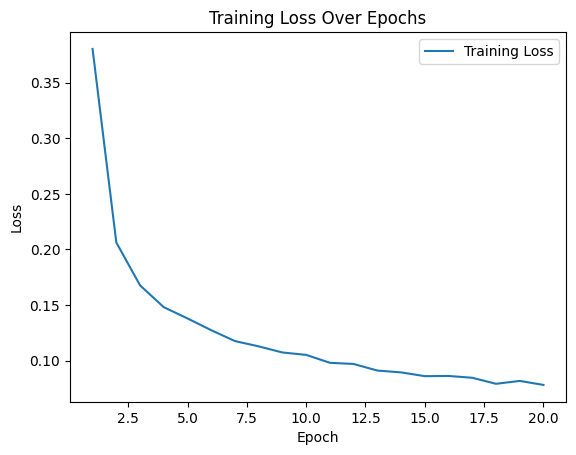

Test Loss: 0.0503
Precision: 0.9834, Recall: 0.9834, F1-Score: 0.9834
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



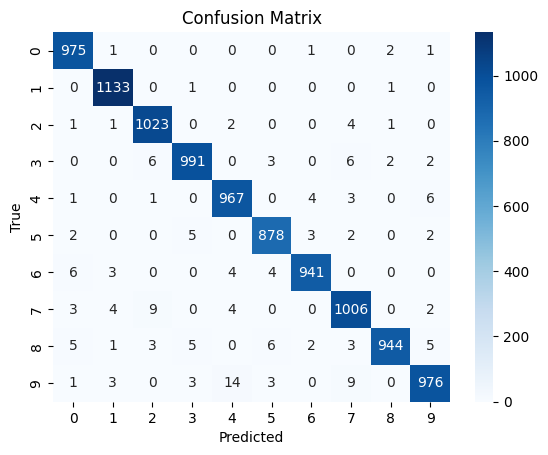

Learning Rate: 0.001, Accuracy: 0.9730
Learning Rate: 0.005, Accuracy: 0.9766
Learning Rate: 0.01, Accuracy: 0.9716
Best Learning Rate: 0.005, Best Accuracy: 0.9766


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define custom weight initialization function
def custom_weight_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        if layer.bias is not None:
            nn.init.constant_(layer.bias, 0)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.BatchNorm1d(hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.BatchNorm1d(hidden_sizes[1]),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_sizes[1], output_size)
        )

    def forward(self, x):
        return self.layers(x)

# Preprocess the MNIST dataset
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(0, scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Hyperparameters
input_size = 28 * 28
hidden_sizes = [256, 128]
output_size = 10
learning_rate = 0.001
epochs = 20

# Initialize model, loss, optimizer
model = MLP(input_size, hidden_sizes, output_size)
model.apply(custom_weight_init)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.view(images.size(0), -1)  # Flatten images

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

# Plot training loss
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

# Evaluate the model
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Hyperparameter tuning example (manual grid search for learning rate)
best_accuracy = 0
best_lr = 0
for lr in [0.001, 0.005, 0.01]:
    model = MLP(input_size, hidden_sizes, output_size)
    model.apply(custom_weight_init)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Train for fewer epochs for tuning
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images = images.view(images.size(0), -1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluate after tuning
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Learning Rate: {lr}, Accuracy: {accuracy:.4f}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lr = lr

print(f"Best Learning Rate: {best_lr}, Best Accuracy: {best_accuracy:.4f}")

# Re-train with the best learning rate if needed

